#### *Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.*

### About

#### 50 000 USD per year is about 4 167 USD monthly.

SOURCE:<br>
http://archive.ics.uci.edu/ml/datasets/Adult <br>
https://www.kaggle.com/overload10/adult-census-dataset/tasks <br>
http://cseweb.ucsd.edu/classes/sp15/cse190-c/reports/sp15/048.pdf

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib import rcParams
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn import metrics
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### Importing the dataset

In [56]:
heading =['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
df = pd.read_csv("adult_data.txt", header=None, names = heading, na_values="?", skipinitialspace = True)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### The number of missing data points per column

In [57]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Dataset has missing values in "age", "occupation", "native-county"

## Data Analysis and Cleaning

### How many people in dataset have income >50K or <=50K

<=50K    24720
>50K      7841
Name: income, dtype: int64


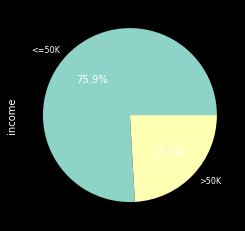

In [58]:
print(df['income'].value_counts())
df['income'].value_counts().plot.pie(autopct='%1.1f%%')

More people earn less or equal 5OK $.

### AGE

In [59]:
def draw_distplot(column, title = ""):
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(20,8))
    sns.distplot(column)

    mean_value = column.mean()
    plt.axvline(mean_value, c='red', linewidth=1.5, label="mean")

    median_value = column.median()
    plt.axvline(median_value, c='blue', linewidth=1.5, label="median")
    plt.legend(loc='upper right', prop={'size': 30})
    plt.title(title)
    plt.show()

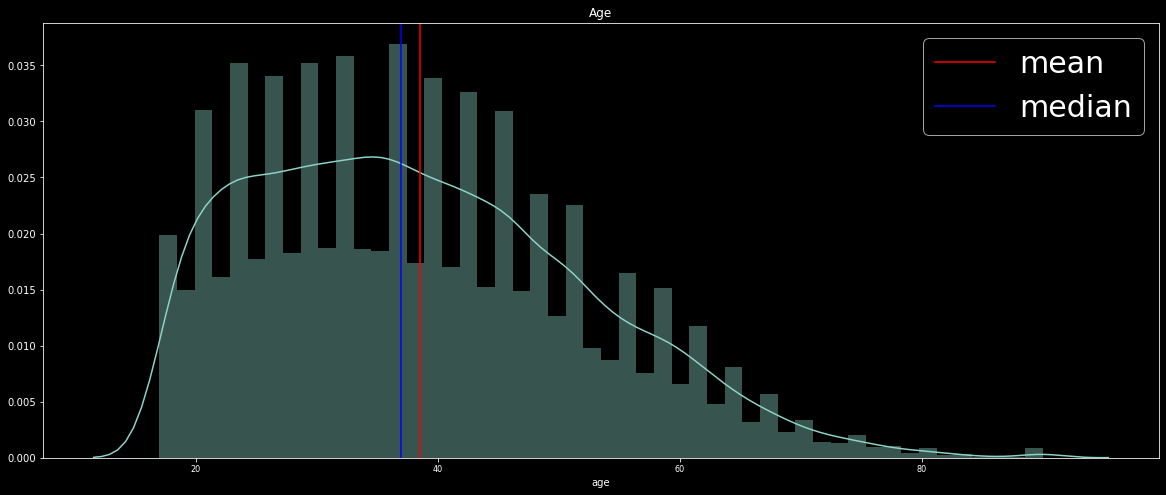

In [60]:
draw_distplot(column=df['age'], title="Age")

In [61]:
print('precise median age for >50K income : ',df[df['income']=='>50K']['age'].median(), 'yrs')

precise median age for >50K income :  44.0 yrs


In [62]:
print('precise median age for <=50K income : ',df[df['income']=='<=50K']['age'].median(), 'yrs')

precise median age for <=50K income :  34.0 yrs


MEDIAN value for people earning <=50K is around 35yrs, presicely.<br>
MEDIAN value for people earing >50K is around 45yrs.<br>
50% people who earn <=50K are between around 25 and 45. <br>
50% people who earn >50K are between around 38 and 50. <br>
IQR for >50K is visibly narrower than for <=50K.<br>

### WORKCLASS

In [63]:
def draw_countplot(countplot_x, countplot_hue, countplot_data, figsize_a=20, figsize_b=10, xticks_rotation=45):
    plt.style.use("dark_background")
    plt.subplots(figsize=(figsize_a, figsize_b))
    plt.xticks(rotation = xticks_rotation)
    plt.rc('xtick',labelsize=8)
    sns.countplot(x = countplot_x, hue = countplot_hue, data = countplot_data)
    plt.legend(prop={'size': 30})
    plt.show()

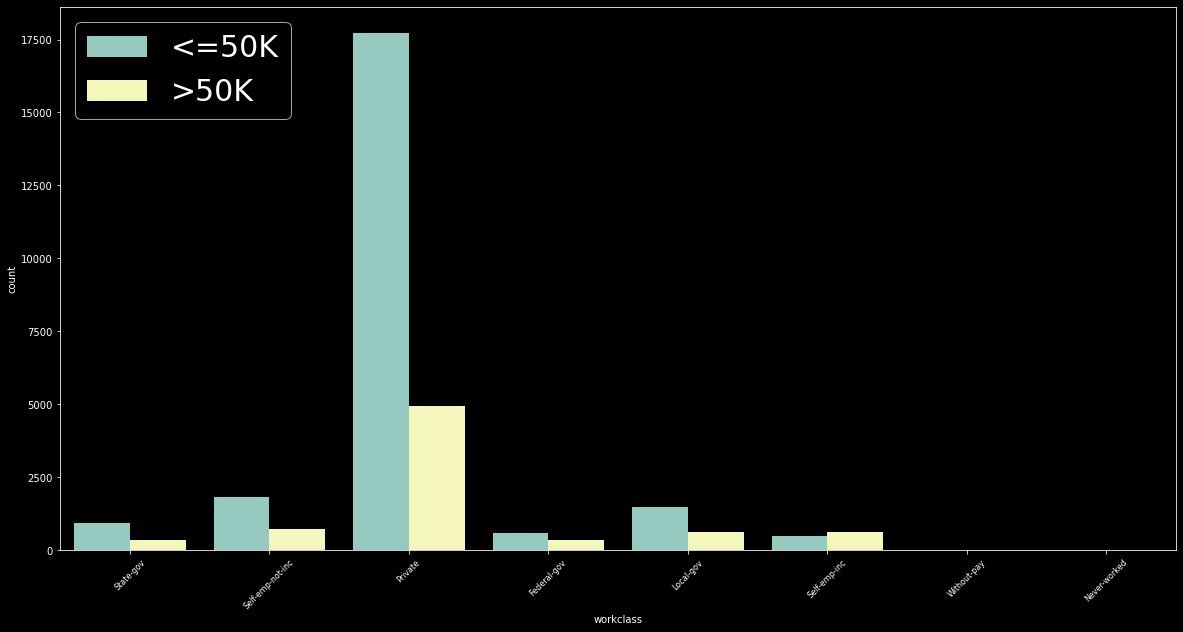

In [64]:
draw_countplot(countplot_x='workclass', countplot_hue='income', countplot_data=df)

The two values **Without-pay** and **Never-worked** are insignificant and I can drop them.

There is **missing data**. How many missing data?

In [65]:
df['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

There is plenty of missing values.

I create **Other** cathegory for missing values and for cathegories with a few members.

In [66]:
pd.isnull(df["workclass"]).value_counts()

False    30725
True      1836
Name: workclass, dtype: int64

In [67]:

df['workclass'].fillna('Other', inplace = True)
df['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
Other                1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

### FNLWGT - Final weight

#### In other words, this is the number of people the census believes the entry represents.

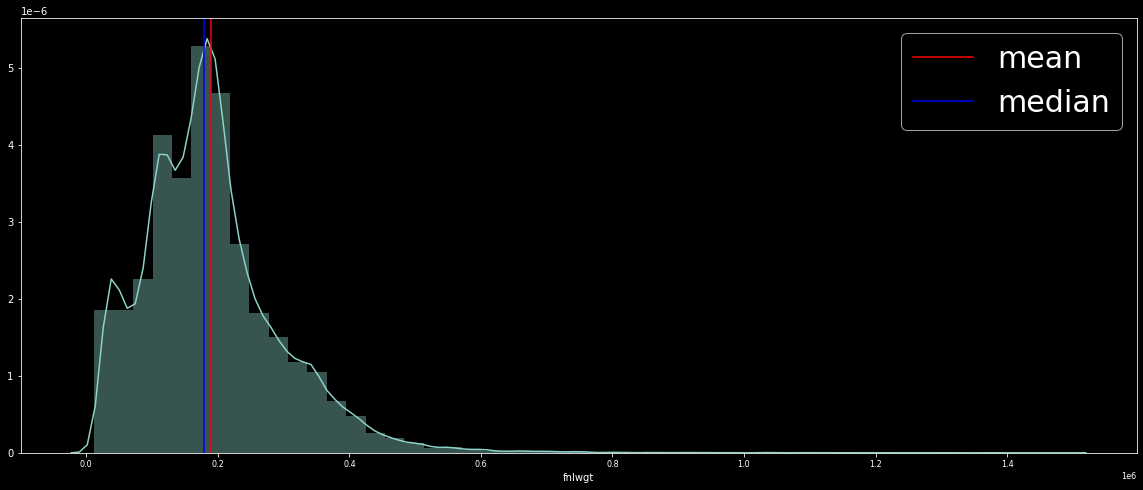

In [68]:
draw_distplot(column=df['fnlwgt'])

This column represents nothing relevant to the futher prediction. <br> So I'm dropping this column:

In [69]:
df = df.drop(['fnlwgt'], axis=1)

### EDUCATION

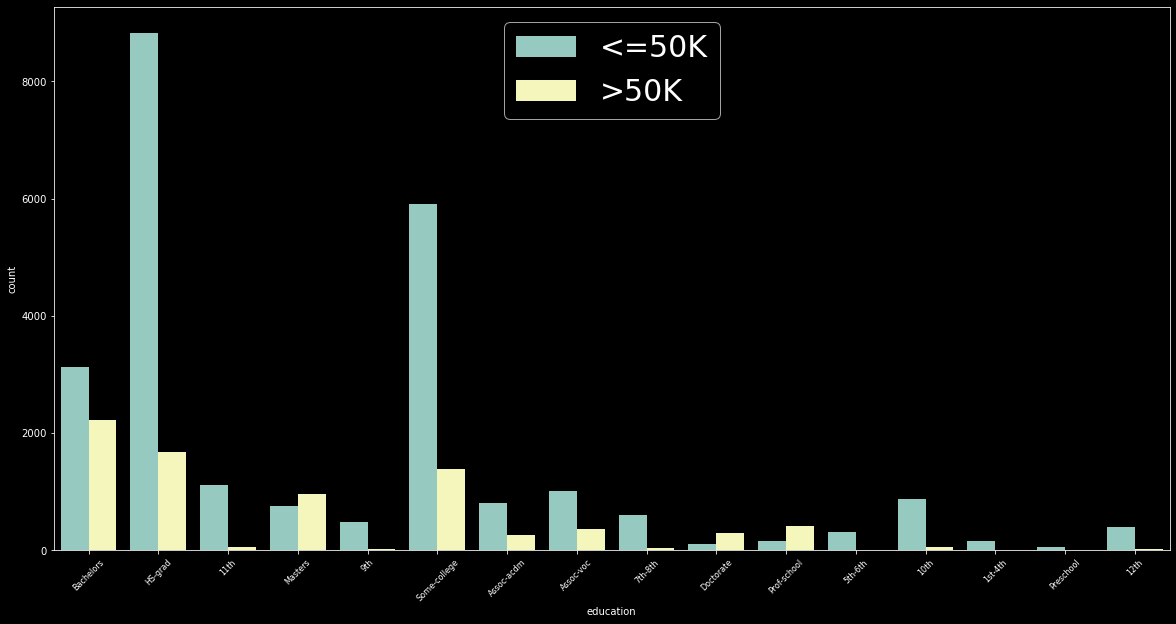

In [70]:
draw_countplot(countplot_x='education', countplot_hue='income', countplot_data=df)

There is no missing values.

### EDUCATION-NUM

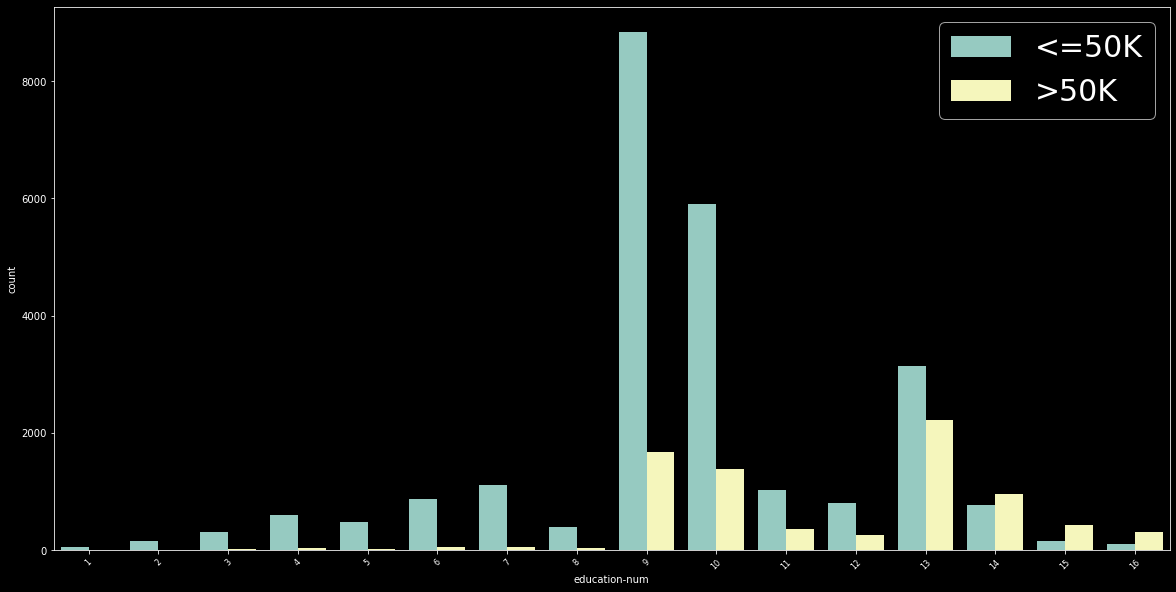

In [71]:
draw_countplot(countplot_x='education-num', countplot_hue='income', countplot_data=df)

There is no missng values. <br> Values aren't linear. Values are categorical.

In [72]:
education_var = df['education'].unique()
for edu_var in education_var:
    print("For {}, the Education Number is {}"
          .format(edu_var, df[df['education'] == edu_var]['education-num'].unique()))

For Bachelors, the Education Number is [13]
For HS-grad, the Education Number is [9]
For 11th, the Education Number is [7]
For Masters, the Education Number is [14]
For 9th, the Education Number is [5]
For Some-college, the Education Number is [10]
For Assoc-acdm, the Education Number is [12]
For Assoc-voc, the Education Number is [11]
For 7th-8th, the Education Number is [4]
For Doctorate, the Education Number is [16]
For Prof-school, the Education Number is [15]
For 5th-6th, the Education Number is [3]
For 10th, the Education Number is [6]
For 1st-4th, the Education Number is [2]
For Preschool, the Education Number is [1]
For 12th, the Education Number is [8]


I see that **Education Number** and **Education** are just the same, so, **Education** of them column could be droped. <br>

In [73]:
df.drop(['education'], axis = 1, inplace = True)

In [74]:
df['education-num'].value_counts()

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education-num, dtype: int64

### MARITAL-STATUS

In [75]:
df['marital-status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

There is no missing values

### OCCUPATION

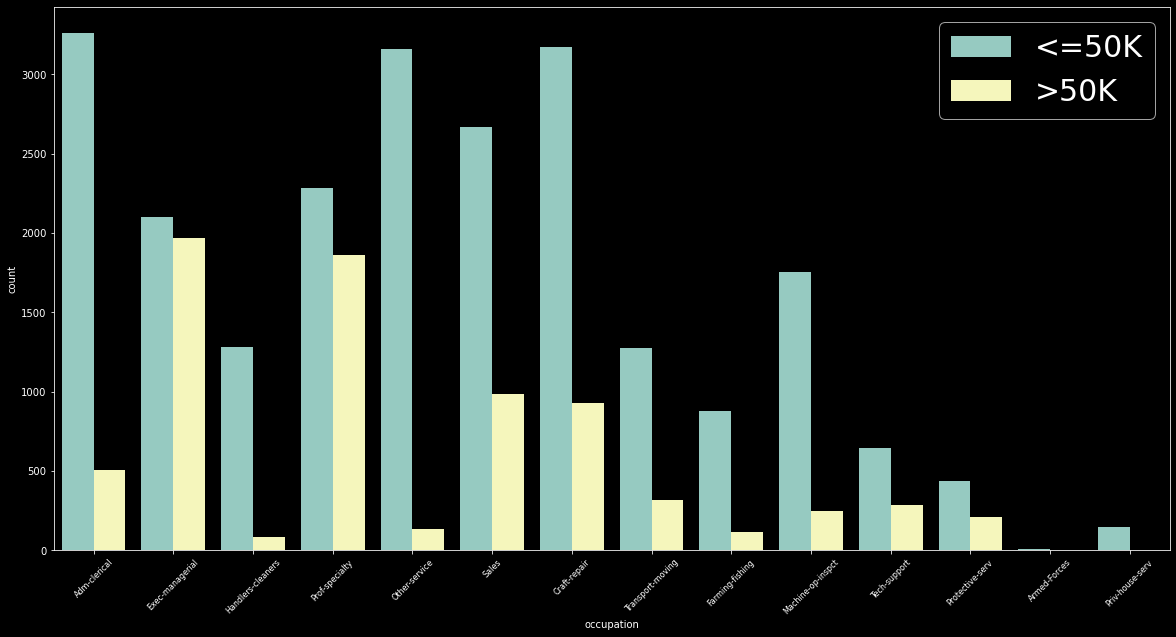

In [76]:
draw_countplot(countplot_x='occupation', countplot_hue='income', countplot_data=df)

In [77]:
df['occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

Do the data have missing values ?. <br>
All variables are unique.<br>


In [78]:
# creating bool series True for NaN values
bool_series = pd.isnull(df["occupation"])
# filtering data
print("displaying data only with team = NaN")
df[bool_series]

displaying data only with team = NaN


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
27,54,Other,10,Married-civ-spouse,NaN,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,Other,4,Married-spouse-absent,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K
69,25,Other,10,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,Other,6,Married-civ-spouse,NaN,Husband,White,Male,0,0,2,United-States,<=50K
106,17,Other,6,Never-married,NaN,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,35,Other,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,>50K
32531,30,Other,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32539,71,Other,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,>50K
32541,41,Other,9,Separated,NaN,Not-in-family,Black,Female,0,0,32,United-States,<=50K


The data have missing values<br>
How many of them?

In [79]:
bool_series.value_counts()

False    30718
True      1843
Name: occupation, dtype: int64

In [80]:
f'Missing values about Occupation is {(df["occupation"].isnull().sum()/(df["occupation"].count()+df["occupation"].isnull().sum())):2.2%} of all data'

'Missing values about Occupation is 5.66% of all data'

As a percentage it looks as if the data loss was not very large. 

I'll create **Other** variable for missing values.

In [81]:
df['occupation'].fillna('Other', inplace = True)
df['occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Other                1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

### RELATIONSHIP

In [82]:
df['relationship'].value_counts()

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

In [83]:
pd.isnull(df["relationship"]).value_counts()

False    32561
Name: relationship, dtype: int64

There is no missing values.

Two columns **Relationship** and **Marital Status** carry similar information.
But no the same so I leave both columns.

### RACE

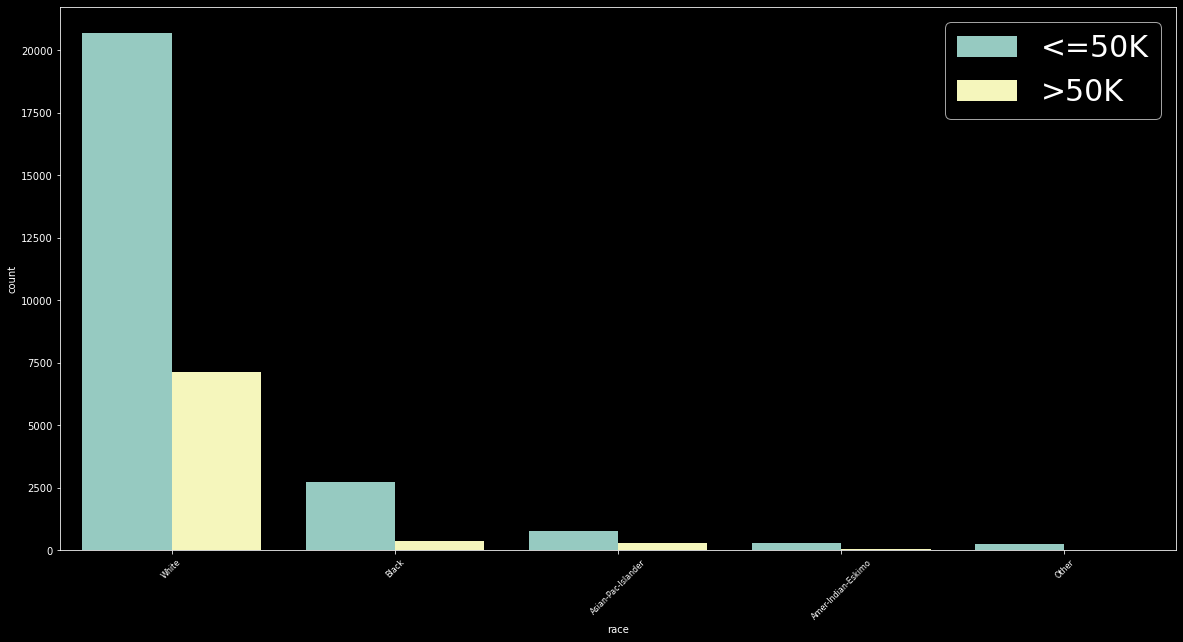

In [84]:
draw_countplot(countplot_x='race', countplot_hue='income', countplot_data=df)

In [85]:
df['race'].replace(['Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],'Other', inplace = True)
df['race'].value_counts()

White    27816
Black     3124
Other     1621
Name: race, dtype: int64

The vast majority of people included in this dataset are of the **White** race. <br> I can sum no White and no Black races to one variable.

### SEX

sex     income
Female  <=50K      9592
        >50K       1179
Male    <=50K     15128
        >50K       6662
Name: income, dtype: int64
------------------------------------------------


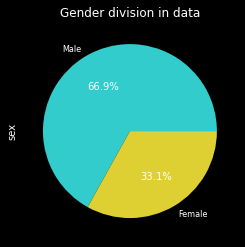

<Figure size 720x432 with 0 Axes>

------------------------------------------------


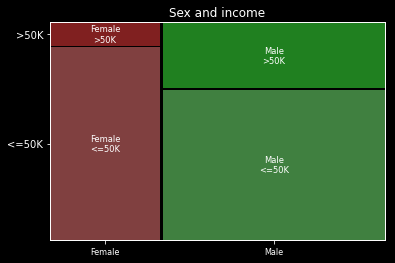

In [86]:
sex_income = pd.DataFrame({'sex': df['sex'], 'income': df['income']})
data = sex_income.income.groupby([sex_income.sex,  sex_income.income]).size()
plt.title('Gender division in data')
print(data)
print('------------------------------------------------')
df['sex'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#33cccc','#ded033'])
plt.figure(figsize=(10,6))
plt.show()
print('------------------------------------------------')
mosaic(data, gap=0.01, title = "Sex and income")
plt.show()

There are more Male participants than Female participants.<br>
More percentage of Male have an Income of more than 50K$ than Females.

### CAPITAL-GAIN and CAPITAL-LOSS

Capital gain - a profit that is made by selling property or an investment <br>
Capital loss - a loss as a result of the sale of an asset

/Users/ola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


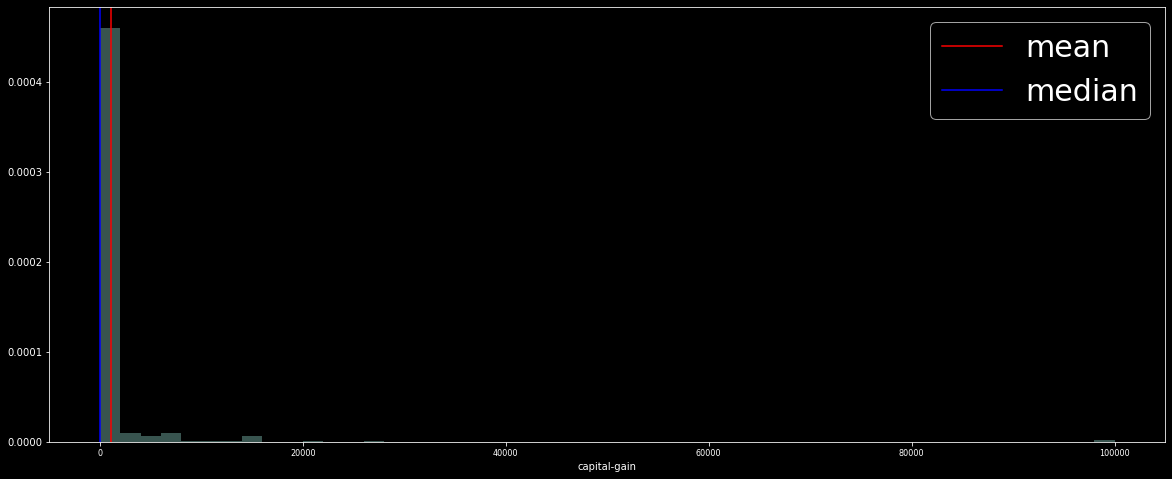

In [87]:
draw_distplot(column=df['capital-gain'])

In [88]:
print(df['capital-gain'].value_counts())

0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
4931         1
1455         1
6097         1
22040        1
1111         1
Name: capital-gain, Length: 119, dtype: int64


/Users/ola/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


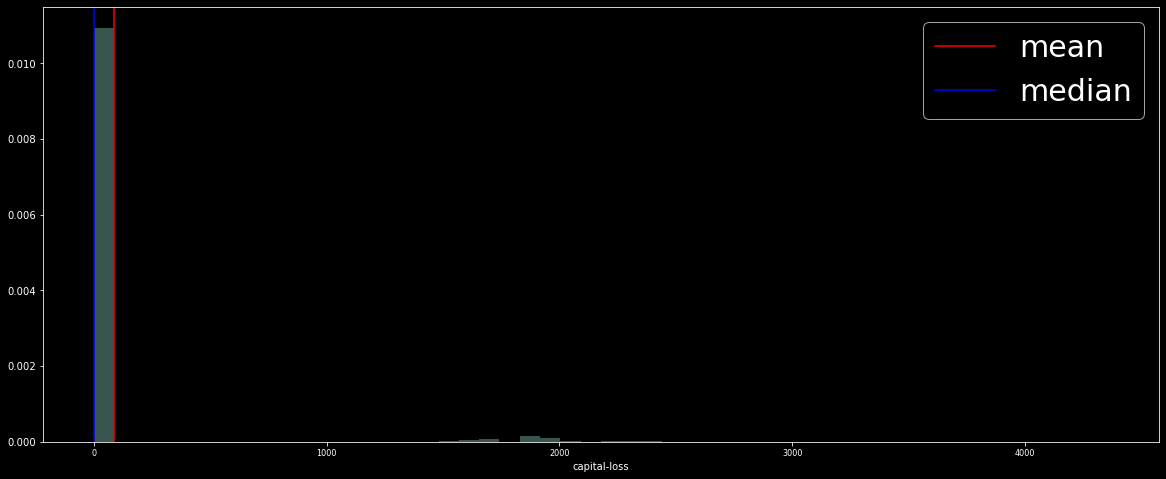

In [89]:
draw_distplot(column=df['capital-loss'])

In [90]:
print(df['capital-loss'].value_counts())

0       31042
1902      202
1977      168
1887      159
1848       51
        ...  
1411        1
1539        1
2472        1
1944        1
2201        1
Name: capital-loss, Length: 92, dtype: int64


### HOURS-PER-WEEK

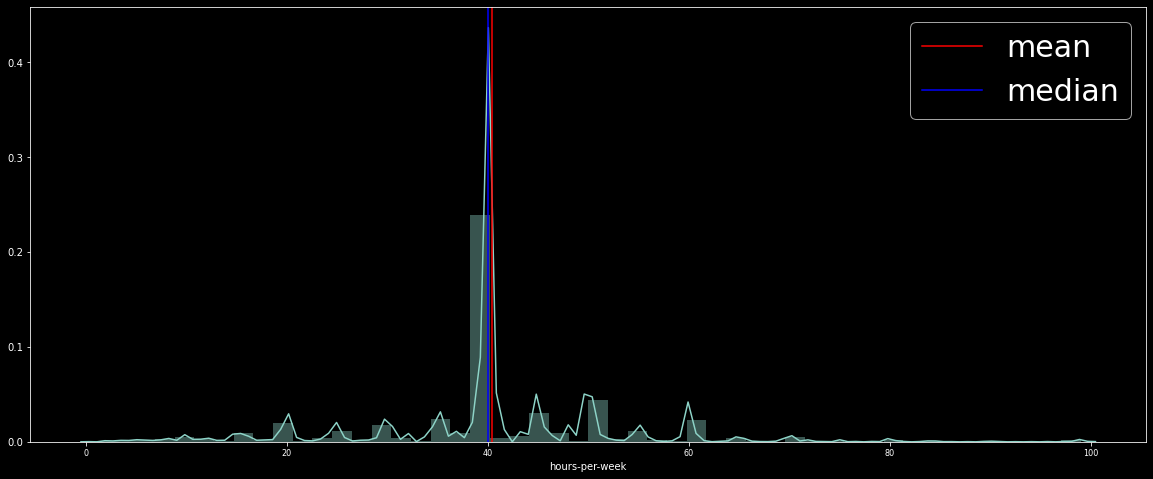

In [91]:
draw_distplot(column=df['hours-per-week'])

Most people work about 40h/week, but data is in range of 0 100

### NATIVE COUNTRIES

In [92]:
print(df['native-country'].value_counts())

United-States                 29170
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

Text(0.5, 1.0, 'Total adults from each Country')

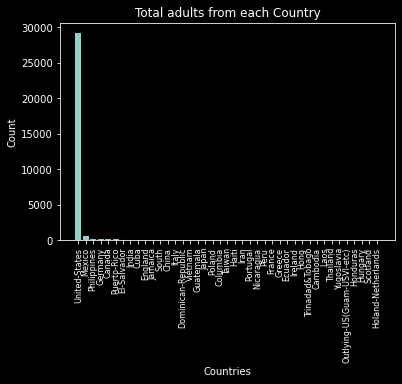

In [93]:
country_count = df['native-country'].value_counts()
plt.style.use("dark_background")
plt.bar(country_count.index, country_count.values)
plt.xticks(rotation = 90)
plt.xlabel('Countries')
plt.ylabel('Count')
plt.title('Total adults from each Country')

There is **"?"** category, which appears to be error. <br>
The majority of people are from **United States** so for the rest I'll create **Other** variable. 

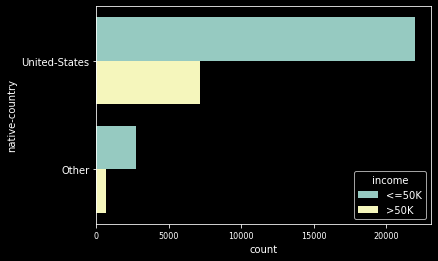

In [94]:
df = df.drop(df[df['native-country'] == '?'].index)
plt.style.use("dark_background")
countries = np.array(df['native-country'].unique())
countries = np.delete(countries, 0)
df['native-country'].replace(countries, 'Other', inplace = True)
sns.countplot(y = 'native-country', hue = 'income', data = df)

### Adding target column with 0/1 values <br>
0 when INCOME <=50K <br>
1 when INCOME >50

In [95]:
df['target'] = df['income']
df['target'] = np.where(df['income'].isin(['>50K']), 1, 0)

id there any missing values in income?

In [96]:
missing_values_income = df['income'].isnull().sum()
print("Missing values in INCOME column ", missing_values_income)

Missing values in INCOME column  0


No missing values in INCOME column

Correlation matrix to identify their relation with income.

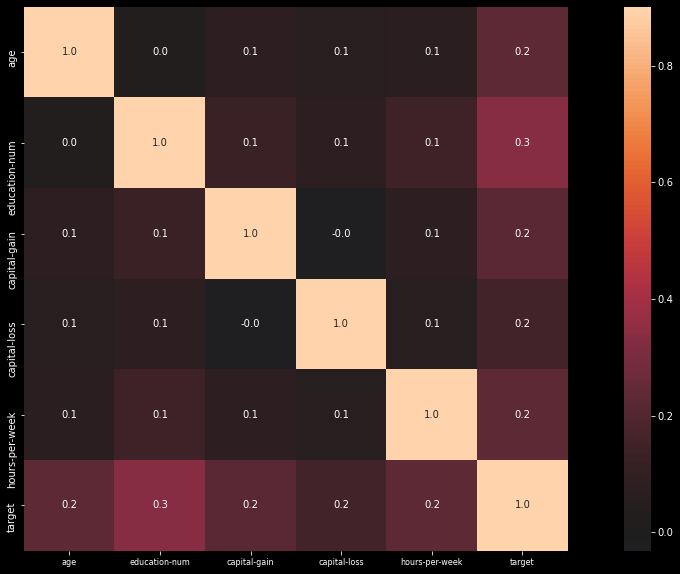

In [97]:
plt.subplots(figsize=(20, 10))
sns.heatmap(df.corr(), vmax=.9, square=True, annot=True, fmt='.1f', center=0)
plt.show()

It’s clear that there is no high linear correlation between any of the continuous features and the target variable.

I'll drop **Income** column, beacuse there is 0/1 **Target** column

In [98]:
df = df.drop(columns=['income'])

### Dataset after all changes

In [99]:
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Other,0


In [100]:
df.isnull().sum()

age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64

## One Hot Encoding

In [101]:
target = 'target'
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [102]:
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X = X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns = new_columns, index = X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_{self.categories_[i][j]}')
                j += 1
        return new_columns

In [103]:
encoder = OneHotEncoder()
encoder_cols = encoder.fit_transform(df[cat_features])

In [104]:
# Add one-hot encoded columns to numerical features and target column
df = pd.concat([pd.concat([df[num_features], encoder_cols], axis=1), df[target]], axis=1)

In [105]:
df.head()

,age,capital-gain,capital-loss,hours-per-week,education-num,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Other,workclass_Private,...,relationship_Unmarried,relationship_Wife,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Other,native-country_United-States,target
0,39,2174,0,40,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0
1,50,0,0,13,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0
2,38,0,0,40,9,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0
3,53,0,0,40,7,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,28,0,0,40,13,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [106]:
features = df.columns.tolist()
features.remove(target)
X = df[features]

y = df[target]

In [107]:
 def ConfusionMatrix(classifier, X=X, y=y, confusionMatrix = True, plotConfusionMatrix = True):
    #split dataset into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, 
                                                        stratify=y)
    
    # Fit the classifier to the data
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    #computing the confusion matrix with each row corresponding to the true class
    if(confusionMatrix):
        print(confusion_matrix(y_test, y_pred))
    
    #drawing Plot Confusion Matrix
    if(plotConfusionMatrix):
        plot_confusion_matrix(classifier, X_test, y_test)  
        plt.show() 

In [108]:
def GridSearch(param, estimator, X=X, y=y):
    # split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    grid_rf = GridSearchCV(estimator, param, refit = True, verbose = 3, n_jobs=-1) 

    # fitting the model for grid search 
    grid_rf.fit(X_train, y_train) 

    # print best parameter after tuning 
    print(grid_rf.best_params_) 
    grid_rf_predictions = grid_rf.predict(X_test) 

    # print classification report 
    print(classification_report(y_test, grid_rf_predictions))

In [113]:
def CVmodel(nFolds = 5, randomState=2020, features=features, lin_reg = False, cutoff=0.5, debug= False,
            model = SVC(), df = df, pipeline = False):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    
    # predictions for individual folds
    predictions = []

    # the index in the original file
    indices = []
    
    if lin_reg:
        for train, test in kf.split(df.index.values):
            if debug:
                print(model)
            model.fit(df.iloc[train][features], df.iloc[train][target])

            # predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
            # preds = model.predict_proba(df.iloc[test][features])[:,1]
            preds, y_test = model.predict(df.iloc[test][features], round(cutoff,1))

            # information about predictions for this fold
            predictions.append(preds.tolist().copy())

            # indexed in the original data frame
            indices.append(df.iloc[test].index.tolist().copy())
            
            feature_importance = model.coef_
            
        return predictions, indices, feature_importance
        
    for train, test in kf.split(df.index.values):
        if debug:
            print(model)

        model.fit(df.iloc[train][features], df.iloc[train][target])

        # predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
        preds = model.predict_proba(df.iloc[test][features])[:,1]

        # information about predictions for this fold
        predictions.append(preds.tolist().copy())

        # indexed in the original data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        if(pipeline):
                return predictions, indices
        
        feature_importance = model.feature_importances_
        
    return predictions, indices, feature_importance

## DECISION TREE

In [ ]:
# Create Decision Tree classifer object
tree = DecisionTreeClassifier()

ConfusionMatrix(classifier=tree, confusionMatrix=False)

In [ ]:
tree = DecisionTreeClassifier()
predictions, indices, feature_importance = CVmodel(model=tree)

tree = {
    "name":"Decision Tree",
    "predictions" : predictions,
    "indices": indices,
    "feature importance": feature_importance
}

In [ ]:
# open the file for binary writing using "with"
with open("models_results/decision_tree.p", "wb") as fp:
    pickle.dump(tree, fp)

## RANDOM FOREST ALGORITHM

In [ ]:
param = {'max_depth': [2, 10, 20],
         'n_estimators': [100, 500],
         'max_features': [10 , 20]}

GridSearch(param = param, estimator = RandomForestClassifier())

Best score: {'max_depth': 20, 'max_features': 10, 'n_estimators': 100}

In [ ]:
param = {'max_depth': [20, 50],
         'max_features': [10, 30],
         'min_samples_split': [10, 30]}

GridSearch(param=param, estimator=RandomForestClassifier())

Best parameters: {'max_depth': 50, 'max_features': 10, 'min_samples_split': 30}

In [ ]:
#Random Forest model 
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=100, 
                                 max_depth=50, max_features=10, min_samples_split=30)

ConfusionMatrix(classifier=rand_forest, confusionMatrix=False)

Saving model:

In [ ]:
rand_forest = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=100, 
                                 max_depth=50, max_features=10, min_samples_split=30)

predictions, indices, feature_importance = CVmodel(model=rand_forest)

random_forest = {
    "name":"Random Forest",
    "predictions": predictions,
    "indices": indices,
    "feature importance": feature_importance
}

In [ ]:
# open the file for binary writing using "with"
with open("models_results/random_forest.p", "wb") as fp:
    pickle.dump(random_forest, fp)

## LINEAR REGRESSION ALGORITHM

Can we use Linear Regression for Classification problem?

In [111]:
class LinearRegression(SklearnLinearRegression):

    def predict(self, X_test, cutoff):
        y_pred = super().predict(X_test) 
        
        # initialise a matrix full with zeros
        y_pred_classes = np.zeros_like(y_pred)
        # add a 1 if the cutoff was breached
        y_pred_classes[y_pred > cutoff] = 1       
        
        return y_pred_classes, y_test
        

In [112]:
def ConfusionMatrixOrHeatMap(y_true, y_pred, confusionMatrix = True, 
                                       HeatmapConfusionMatrix = True):
    #confusion matrix
    c = confusion_matrix(y_true, y_pred)
    
    if(confusionMatrix):
        return c
    if(HeatmapConfusionMatrix):
        #drawing Plot Confusion Matrix
        sns.heatmap(c, annot=True, fmt="d")
        plt.show() 

In [ ]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#create object of LinearRegression class
lr = LinearRegression()
# Fit the classifier to the data
lr.fit(X=X_train, y=y_train)
#classifing prediction by threshold 0.7
y_pred_classes, y_test_lr = lr.predict(X_test, 0.5)

ConfusionMatrixOrHeatMap(y_test_lr, y_pred_classes, confusionMatrix = False)


Changing cutoff

In [ ]:
#create object of LinearRegression class
lr = LinearRegression()
# Fit the classifier to the data
lr.fit(X=X_train, y=y_train)
#classifing prediction by threshold 0.7
y_pred_classes, y_test_lr = lr.predict(X_test, 0.7)

ConfusionMatrixOrHeatMap(y_test_lr, y_pred_classes, confusionMatrix = False)

Checking best cutoff by ROC AUC:

In [110]:
def plotROCs(results, debug=False):
    # Determining the size of the drawing
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        
        # Calculation of the points needed to draw the ROC curve
        # the roc_curve function concludes three data series, fpr, 
        #tpr, and cutoff levels
        fpr, tpr, thresholds = roc_curve(true, pred)
        
        # We calculate the area under the curve
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)
        
        # curve thickness
        lw = 2

        # We draw the ROC curve
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
        
    # We draw a 45 degree curve as a reference point
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    # We add light margins to the range so that the curve 
    #does not coincide with the axes
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    if debug:
        plt.savefig('ROC.png')
    plt.show()

In [ ]:
lr = LinearRegression()
res2plot = []
true = (df[target]==1)
for cutoff in np.arange(0, 1.1, 0.1):
    predictions, indices = CVmodel(model=lr, lin_reg=True, cutoff=cutoff)
    pred = pd.Series(sum(predictions, []), 
                     index=sum(indices, [])).sort_index()
    res2plot.append((true, pred, "%.1f" % round(cutoff,1)))
plotROCs(res2plot, debug=True)

The best ROC-AUC score has model with cutoff = 0.3

Saving model:

In [ ]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
lr = LinearRegression()
predictions, indices, feature_importance = CVmodel(model=lr, lin_reg=True, cutoff=0.3)

linear_regression = {
    "name":"Linear Regression",
    "predictions": predictions,
    "indices": indices,
    "feature importance": feature_importance
}

In [ ]:
# open the file for binary writing using "with"
with open("models_results/linear_regression.p", "wb") as fp:
    pickle.dump(linear_regression, fp)

## LOGISTIC REGRESSION ALGORITHM

In [ ]:
#Standardization of data and KNN model 
logreg_scaler = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('logreg', LogisticRegression())
                ])
ConfusionMatrix(classifier=logreg_scaler, confusionMatrix=False)

In [ ]:
predictions, indices = CVmodel(model=logreg_scaler, pipeline = True)
feature_importance = logreg_scaler.steps[1][1].coef_[0]
logistic_regression = {
    "name":"Logistic Regression",
    "predictions": predictions,
    "indices": indices,
    "feature importance": feature_importance
}

In [ ]:
# open the file for binary writing using "with"
with open("models_results/logistic_regression.p", "wb") as fp:
    pickle.dump(logistic_regression, fp)

## K-NEAREST NEIGHBORS ALGORITHM

In [ ]:
#Standardization of data and KNN model 
pipe = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())
                ])

param = {'knn__n_neighbors': [10, 100],
         'knn__weights': ['uniform', 'distance'],
         'knn__p': [1, 2]}

GridSearch(param=param, estimator=pipe)

Best parameters: {'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'uniform'}

In [ ]:
#Standardization of data and KNN model 
pipe = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())
                ])

param = {'knn__n_neighbors': [10, 50],
         'knn__weights': ['uniform'],
         'knn__p': [1]}

GridSearch(param=param, estimator=pipe)

 Best parameters: {'knn__n_neighbors': 50, 'knn__p': 1, 'knn__weights': 'uniform'}

In [ ]:
#Standardization of data and KNN model 
knn_standarization = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=50, p=1, weights='uniform'))
                ])

ConfusionMatrix(classifier=knn_standarization, confusionMatrix=False)

Saving model:

In [115]:
#Standardization of data and KNN model 
knn_standarization = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=50, p=1, weights='uniform'))
                ])

predictions, indices = CVmodel(model=knn_standarization, pipeline=True)

In [ ]:
knn = {
    "name":"K-Nearest Neighbours",
    "predictions": predictions,
    "indices": indices,
}

In [ ]:
# open the file for binary writing using "with"
with open("models_results/k-nearest_neighbours.p", "wb") as fp:
    pickle.dump(knn, fp)

## SUPPORT VECTOR MACHINE ALGORITHM

In [ ]:
# split into a training and testing set
pipe = Pipeline(steps=[
                ('scaler', StandardScaler()), 
                ('svc', SVC())
                ])

param = {'svc__C': [1, 10],
         'svc__kernel': ['linear', 'poly']}

GridSearch(param=param, estimator=pipe)

Best parameters: {'C': 1, 'kernel': 'linear'}

In [ ]:
# split into a training and testing set
pipe = Pipeline(steps=[
                ('scaler', StandardScaler()), 
                ('svc', SVC())
                ])

param = {'svc__kernel': ['linear', 'rbf'],
         'svc__gamma': ['scale', 'auto']
        }

GridSearch(param=param, estimator=pipe)

Best parameters: {'gamma': 'scale', 'kernel': 'linear'}

#### Saving SVM model to file

In [ ]:
#Standardization of data and KNN model 
svm_standarization = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('svm',  SVC(kernel='linear', C=1, gamma='scale', probability=True))
                ])

ConfusionMatrix(classifier=svm_standarization, confusionMatrix=False)

Saving model

In [149]:
#Standardization of data and KNN model 
svm_standarization = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('svm',  SVC(kernel='linear', C=1, gamma='scale', probability=True))
                ])
predictions, indices = CVmodel(model=svm_standarization, pipeline=True)
feature_importance = svm_standarization.steps[1][1].coef_[0]
svm = {
    "name":"Support Vector Machine",
    "predictions": predictions,
    "indices": indices,
    "feature importance": feature_importance
}

In [150]:
# open the file for binary writing using "with"
with open("models_results/support_vector_machine.p", "wb") as fp:
    pickle.dump(svm, fp)

# Summary

In [151]:
# Let's also load previously saved models
with open("models_results/decision_tree.p", "rb") as fp:
    tree = pickle.load(fp)
    
with open("models_results/random_forest.p", "rb") as fp:
    rand_forest = pickle.load(fp)
    
with open("models_results/linear_regression.p", "rb") as fp:
    lin_reg = pickle.load(fp)
    
with open("models_results/logistic_regression.p", "rb") as fp:
    log_reg = pickle.load(fp)
    
with open("models_results//k-nearest_neighbours.p", "rb") as fp:
    knn = pickle.load(fp)
    
with open("models_results/support_vector_machine.p", "rb") as fp:
    svm = pickle.load(fp)

In [ ]:
listOfResults = []
true = (df[target]==1)
for result in [tree, rand_forest, lin_reg, log_reg, knn, svm]:
#     print(result)
    pred = pd.Series(sum(result["predictions"], []), 
                     index=sum(result["indices"], [])).sort_index()
    
    listOfResults.append((true, pred, result["name"]))
    
# We call the drawing function
plotROCs(listOfResults)

Which feature has the bigest importance?

## Decision Tree Feature Importance

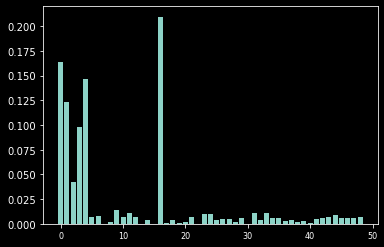

In [143]:
# for i,v in enumerate(tree["feature importance"]):
# 	print('Feature: %s, Score: %.5f' % (features[i],v))
# plot feature importance
plt.bar([x for x in range(len(tree["feature importance"]))], tree["feature importance"])
plt.show()

It's a lot of features so I choose 10 top most important features in model

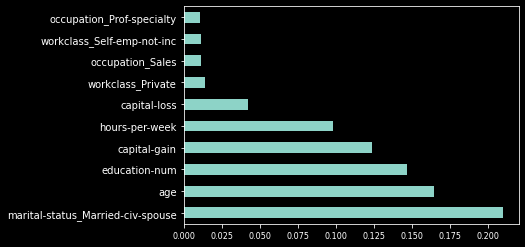

In [144]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(tree["feature importance"], index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


<u>Marital status: Married civ spouse</u> has the most importance in Decision Tree model

## Random Forest Feature Importance

I'll see top 10 important features

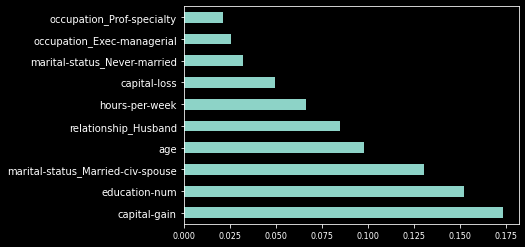

In [145]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rand_forest["feature importance"], index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<u>Capital gain</u> has the most importance in Random Forest Classifier

## Linear Regression Feature Importance

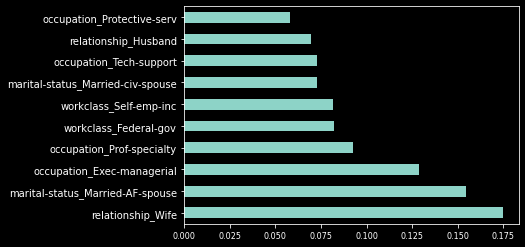

In [146]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(lin_reg["feature importance"], index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<u>Relationship: Wife</u> in Linear Regression is taken for the most important feature

## Logistic Regression Feature Importance

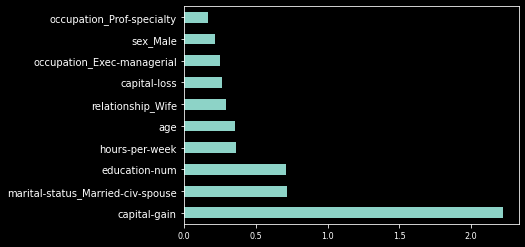

In [147]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(log_reg["feature importance"], index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<u> Capital gain</u> has the most importance in Logistic Regression model

## K Nearest Neighbours Feature Importance

## SVM Feature Importance

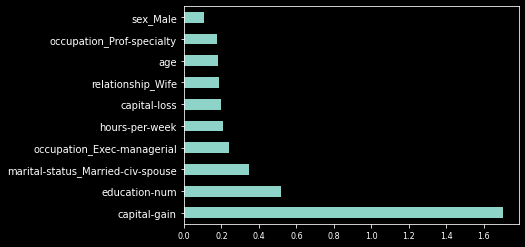

In [152]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(svm["feature importance"], index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<u>Capita gain</u> has the most importance in SVM

In [ ]:
Summary: I see that the most importance have capital gain or Relationship/

# opis

In [3]:
heading =['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
df = pd.read_csv("adult_data.txt", header=None, names = heading, na_values="?", skipinitialspace = True)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
